# Generar Dataset

In [1]:
# import the packages
import os
import torchaudio
import IPython.display as ipd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import soundfile as sf
import librosa as lb
import numpy as np
import cv2 as cv
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary

In [2]:
train_df = pd.read_csv("birdclef_2023/train_metadata.csv").sort_values('primary_label',ascending=True)
train_df.head()

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename
0,abethr1,[],['song'],4.3906,38.2788,Turdus tephronotus,African Bare-eyed Thrush,Rolf A. de By,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/128013,abethr1/XC128013.ogg
13,abethr1,[],"['adult', 'call', 'sex uncertain', 'song']",-2.9858,37.5975,Turdus tephronotus,African Bare-eyed Thrush,isaac kilusu,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/639039,abethr1/XC639039.ogg
12,abethr1,[],"['adult', 'sex uncertain', 'song']",-2.9858,37.5975,Turdus tephronotus,African Bare-eyed Thrush,isaac kilusu,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/616997,abethr1/XC616997.ogg
11,abethr1,"['eswdov1', 'helgui', 'rindov']",['song'],-2.8802,38.1861,Turdus tephronotus,African Bare-eyed Thrush,Sidney Shema,Creative Commons Attribution-NonCommercial-Sha...,4.5,https://www.xeno-canto.org/606253,abethr1/XC606253.ogg
10,abethr1,[],['song'],NaN,NaN,Turdus tephronotus,African Bare-eyed Thrush,isaac kilusu,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/585802,abethr1/XC585802.ogg


In [3]:
train_df = pd.concat([train_df, pd.get_dummies(train_df['primary_label'])], axis=1)

In [4]:
# Split data extracted from https://www.kaggle.com/code/nischaydnk/split-creating-melspecs-stage-1
# Consider classes with only one audio file in the train. Also stratify the split.
def birds_stratified_split(df, target_col, test_size=0.2):
    class_counts = df[target_col].value_counts()
    low_count_classes = class_counts[class_counts < 2].index.tolist() ### Birds with single counts

    df['train'] = df[target_col].isin(low_count_classes)

    train_df, val_df = train_test_split(df[~df['train']], test_size=test_size, stratify=df[~df['train']][target_col], random_state=42)

    train_df = pd.concat([train_df, df[df['train']]], axis=0).reset_index(drop=True)

    # Remove the 'train' column
    train_df.drop('train', axis=1, inplace=True)
    val_df.drop('train', axis=1, inplace=True)

    return train_df, val_df

In [5]:
train_df, val_df = birds_stratified_split(train_df, 'primary_label')

In [6]:
# Extract only the labels of a row
torch.tensor(train_df.iloc[0][12:]).float()

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 

In [7]:
# Code adapted from https://www.kaggle.com/code/nischaydnk/split-creating-melspecs-stage-1
# The idea is generate the spectrogram of the audio
class Config:
    sampling_rate = 32000
    duration = 5 
    fmin = 0
    fmax = None 

def compute_melspec(y, sr, n_mels, fmin, fmax):
    """
    Computes a mel-spectrogram and puts it at decibel scale
    Arguments:
        y {np array} -- signal
        params {AudioParams} -- Parameters to use for the spectrogram. Expected to have the attributes sr, n_mels, f_min, f_max
    Returns:
        np array -- Mel-spectrogram
    """
    melspec = lb.feature.melspectrogram(
        y=y, sr=sr, n_mels=n_mels, fmin=fmin, fmax=fmax,
    )

    melspec = lb.power_to_db(melspec).astype(np.float32)
    return melspec

def mono_to_color(X, eps=1e-6, mean=None, std=None):
    mean = mean or X.mean()
    std = std or X.std()
    X = (X - mean) / (std + eps)
    
    _min, _max = X.min(), X.max()

    if (_max - _min) > eps:
        V = np.clip(X, _min, _max)
        V = 255 * (V - _min) / (_max - _min)
        V = V.astype(np.uint8)
    else:
        V = np.zeros_like(X, dtype=np.uint8)

    return V

def crop_or_pad(y, length, is_train=True, start=None):
    if len(y) < length:
        y = np.concatenate([y, np.zeros(length - len(y))])
        
        n_repeats = length // len(y)
        epsilon = length % len(y)
        
        y = np.concatenate([y]*n_repeats + [y[:epsilon]])
        
    elif len(y) > length:
        if not is_train:
            start = start or 0
        else:
            start = start or np.random.randint(len(y) - length)

        y = y[start:start + length]

    return y

class AudioToImage:
    def __init__(self, sr=Config.sampling_rate, n_mels=128, fmin=Config.fmin, fmax=Config.fmax, 
                 duration=Config.duration, step=None, res_type="kaiser_fast", resample=True, train=True):

        self.sr = sr
        self.n_mels = n_mels
        self.fmin = fmin
        self.fmax = fmax or self.sr//2

        self.duration = duration
        self.audio_length = self.duration*self.sr
        self.step = step or self.audio_length
        
        self.res_type = res_type
        self.resample = resample

        self.train = train
        
    def audio_to_image(self, audio):
        melspec = compute_melspec(audio, self.sr, self.n_mels, self.fmin, self.fmax ) 
        image = mono_to_color(melspec)
        return image

    def __call__(self, row):
        audio, orig_sr = sf.read(os.path.join("birdclef_2023/train_audio", row.filename), dtype="float32")
        
        if self.resample and orig_sr != self.sr:
            audio = lb.resample(audio, orig_sr, self.sr, res_type=self.res_type)
        
        
        audios = [audio[i:i+self.audio_length] for i in range(0, max(1, len(audio) - self.audio_length + 1), self.step)]
        audios[-1] = crop_or_pad(audios[-1] , length=self.audio_length)
        images = [self.audio_to_image(audio) for audio in audios]
        images = np.stack(images)
        
        return  row.filename, images

In [17]:
# Función para generar el dataset

class AudioDataset(Dataset):
    def __init__(self, df, main_path, transform = False, train = True):
        self.metadata = df
        self.main_path = main_path
        self.transform = transform
        self.transforms = transforms.Compose([transforms.ToPILImage(),
                                              transforms.Resize((81,201)), 
                                              transforms.ToTensor()
                                             ])
        self.train = train

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        label = torch.tensor(self.metadata.iloc[idx][12:]).float()

        filename = self.metadata.iloc[idx].filename
        file_path = os.path.join(self.main_path, filename)
        converter = AudioToImage(step=int(Config.duration*0.666*Config.sampling_rate))
        _, images = converter.__call__(self.metadata.iloc[idx])
        image = images[:5]
        
        ########## RANDOM SAMPLING ################
        if self.train:
            image = image[np.random.choice(len(image))]
        else:
            image = image[0]
        ###########################################    
            
        image = torch.tensor(image).float()
        image = torch.stack([image, image, image])
        # NORMALIZE
        image = image / 255.0

        if self.transform:
            image = self.transforms(image)
        
        return image, label

In [18]:
train_dataset = AudioDataset(train_df, "birdclef_2023/train_audio", True)
val_dataset = AudioDataset(val_df, "birdclef_2023/train_audio", True, False)

torch.Size([3, 81, 201])
torch.Size([264])
torch.Size([3, 81, 201])
torch.Size([264])
torch.Size([3, 81, 201])
torch.Size([264])
torch.Size([3, 81, 201])
torch.Size([264])


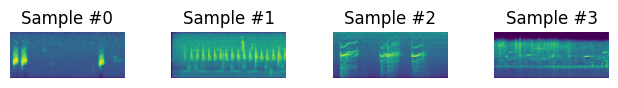

In [19]:
fig = plt.figure()

for i, sample in enumerate(train_dataset):
    spectro = sample[0]
    label = sample[1]
    print(spectro.shape)
    print(label.shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    #ax.set_title('Sample #{}'.format(i))
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    #plt.imshow(spectro.log2()[0,:,:].numpy(), cmap='viridis')
    plt.imshow(spectro[0], cmap='viridis')

    if i == 3:
        plt.show()
        break

# Dataloader

In [20]:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=15,
    num_workers=2,
    shuffle=True
)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=15,
    num_workers=2,
    shuffle=True
)

# Crear modelo

In [21]:
120*305*64*0.5*0.5

585600.0

In [22]:
94*34*64*0.5*0.5

51136.0

In [14]:
class CNNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.flatten = nn.Flatten()
        #self.fc1 = nn.Linear(585600, 2000)
        self.fc1 = nn.Linear(51136, 2000)
        self.fc2 = nn.Linear(2000, 264)


    def forward(self, x):
        #print(x.shape)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        #print(x.shape)
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        #print(x.shape)
        #x = x.view(x.size(0), -1)
        x = self.flatten(x)
        #print(x.shape)
        x = F.relu(self.fc1(x))
        #print(x.shape)
        x = F.dropout(x, training=self.training)
        #print(x.shape)
        x = F.relu(self.fc2(x))
        #x = x.unqueeze(1)
        #print(x.shape)
        return x
        #
        #return F.log_softmax(x,dim=1)  

device = 'cuda'
model = CNNet().to(device)

In [15]:
# cost function used to determine best parameters
cost = torch.nn.BCEWithLogitsLoss()

# used to create optimal parameters
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Create the training function

def train(dataloader, model, loss, optimizer):
    model.train()
    size = len(dataloader.dataset)
    for batch, (X, Y) in enumerate(dataloader):
        
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        pred = model(X)
        loss = cost(pred, Y)
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f'loss: {loss:>7f}  [{current:>5d}/{size:>5d}]')

# Create the validation/test function

def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, ttp, tfp = 0, 0, 0

    with torch.no_grad():
        for batch, (X, Y) in enumerate(dataloader):
            X, Y = X.to(device), Y.to(device)
            pred = model(X)

            test_loss += cost(pred, Y).item()
            #correct += (pred.round()==Y).type(torch.float).sum().item()
            pred = pred.round()
            tp = torch.add(pred, Y)
            tp = torch.where(tp > 1, 1.0, 0.0)
            tp = tp.type(torch.float).sum().item()
            ttp += tp
            
            fp = torch.sub(pred, Y) #->fp contar los 2
            fp = torch.where(fp > 0, 1.0, 0.0)
            fp = fp.type(torch.float).sum().item()
            tfp += fp

    test_loss /= size
    #correct /= size
    if (ttp + tfp) == 0:
        mAP = 0
    else:
        mAP = ttp/(ttp+tfp) # micro average precision

    print(f'\nTest Error:\nmAP: {(100*mAP):>0.1f}%, avg loss: {test_loss:>8f}\n')


In [16]:
epochs = 15

for t in range(epochs):
    print(f'Epoch {t+1}\n-------------------------------')
    train(train_dataloader, model, cost, optimizer)
    test(test_dataloader, model)
print('Done!')

Epoch 1
-------------------------------
loss: 0.698119  [    0/13554]
loss: 0.693151  [ 1500/13554]



KeyboardInterrupt

